# Определение порядка водотоков

Для подготовки данных были произведены следующие действия:
* Перевод слоя полигональных объектов в линейные: ВЕКТОР - ОБРАБОТКА ГЕОМЕТРИИ - ПРЕОБРАЗОВАТЬ ПОЛИГОНЫ В ЛИНИИ (QGIS)
* Объединение линейных векторных слоев: ВЕКТОР - ГЕООБРАБОТКА - ОБЪЕДИНЕНИЕ (QGIS)
* Разбиение линий на сегменты: АНАЛИЗ - ВЕКТОРНЫЙ ОВЕРЛЕЙ - РАЗБИТЬ ЛИНИЯМИ (QGIS)
* Задание новых полей с индексами: PYTHON
* Извлечение вершин на пересечениях сегментов: ВЕКТОР - АНАЛИЗ - ПЕРЕСЕЧЕНИЯ ЛИНИЙ (QGIS)

В результате преобразований был получен следующий векторный слой: v_new.shp

In [1]:
# Загрузим все нужные библиотеки 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random
import time
import networkx as nx
import pandas as pd
import geopandas, geoplot

## Загрузка векторного слоя 

In [2]:
data = geopandas.read_file('/media/mikhail/Data/Ob/Simple_example/v_new.shp')
data.head(5)

,id,NEW,id_2,NEW_2,geometry
0,1,1,1,2,POINT (30.99791 59.93690)
1,1,1,2,5,POINT (30.99791 59.93690)
2,1,2,1,1,POINT (30.99791 59.93690)
3,1,2,1,3,POINT (30.75824 59.76402)
4,1,2,2,5,POINT (30.99791 59.93689)


## Формирование графа

На данном этапе данные можно описать следующим образом. Точки находятся на пересечениях сегментов. Все сегменты рек проиндексированы в поле NEW, все реки (которые состоят из нескольких сегментов) проиндексированы с помощью значений поля id. В результате определения точек пересечния сегментов, таблица атрибутов была преобразована. Были сформированы поля id_2 и NEW_2 - то есть точка характеризуется двуям парами полей: "id" и "NEW". Рассмотрим пару полей NEW и NEW_2, так как в дальнейшем будем использовать именно их. Каждая строка - это точка пересчения сегментов, в таком случае сегмент реки NEW через данную точку имеет пересечение с NEW_2. 

Таким образом, если рассматривать сегменты реки как вершины, а их связи/пересечения как ребра, то таблицу, составленную из полей NEW и NEW2 можно воспринимать как список смежности.

In [3]:
list_of_adjacencies = data[['NEW', 'NEW_2']]
list_of_adjacencies = np.array(list_of_adjacencies)

# Функция для приведения списка смежности к нужному формату
def prepare(list_of_adjacencies):
    lines = []
    for i in list_of_adjacencies:
        i_0 = str(i[0])
        i_1 = str(i[1])
        string = i_0 + ' ' + i_1
        lines.append(string)
    return(lines)

lines = prepare(list_of_adjacencies)
G = nx.parse_adjlist(lines, nodetype = int)
print('Было: \n', list_of_adjacencies[0:2], '\n')
print('Стало: \n', lines[0:2], '\n')
# Посмотрим, корректно ли мы опередили граф
print('Список всех вершин (сегментов реки):', G.nodes())

Было: 
 [[1 2]
 [1 5]] 

Стало: 
 ['1 2', '1 5'] 

Список всех вершин (сегментов реки): [1, 2, 5, 3, 6, 4, 7]


Визуализируем граф

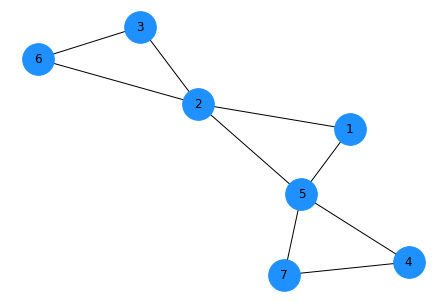

In [4]:
nx.draw(G,pos=nx.spring_layout(G), with_labels=True, node_color='#1E90FF', node_size=1000) 

Стоит обратить внимание, что граф, составленный по гидрологической сети таким образом содержит много циклов.

Основные этапы обработки можно описать в виде схемы:
![Flow.png](https://raw.githubusercontent.com/Dreamlone/State_Hydrological_Institute/master/images/flow.png)

Первые этапы выполнялись над векторным слоем водотоков в геоинформационной системе QGIS. Алгоритм обхода графа осуществлялся с помощью скриптов на Python.

## Алгоритм присваивания вершинам (сегментам реки) их порядка в речной сети

Мы предполагаем, что нам известно, какой сегмент в речной сети является замыкающим (устье реки). Поэтому присваивание атрибутов будет происходить, начниая именно с него. В данном примере номер сегмена, с которого мы будем начинать обход графа - 1.

Код ниже присваивает замыкающему сегменту ранг 1, всем сегментам, впадающим в замыкающий - ранг 2, все сегменты, впадающие в притоки второго ранга - ранг 3 и т.д.

### 1. Присваивание ранга кажому сегменту (атрибут 'rank')

In [5]:
# Количество вершин в графе
nodes_amount = len(G.nodes())
print('Количество вершин в графе -', nodes_amount)

# Функция для присваивания атрибутов вершинам графа
def attr_set(G, start):
    # Начальной вершине присвоим значением атрибута - 1
    attrs = {start: {'rank' : 1}}
    nx.set_node_attributes(G, attrs)
    
    # Список со всеми вершинами, до которых можно добраться из точки start
    # при помощи поиска в ширину
    vert_list = list(nx.bfs_successors(G, source = start)) 

    # Цикл обхода графа с присваиванием меток вершинам
    # Каждая компонента - это небольшой подграф
    for component in vert_list:
        vertex = component[0] # Вершина в которой находимся на данной итерации
        neighbors = component[1] # Вершины, которые являются соседними (которые мы еще не посещали)
        
        # Добавление атрибута - количество потомков у данной вершины
        n_offspring = len(neighbors)
        attrs = {vertex: {'offspring' : n_offspring}}
        nx.set_node_attributes(G, attrs)
        
        # Значение атрибута в рассматриваемой вершине
        att = G.nodes[vertex].get('rank')
        if att != None:
            # Значение атрибута, которое будет присвоено соседним вершинам
            att_number = att + 1
        
        # Для каждого соседа производим присваивание атрибута
        for i in neighbors:
            attrs = {i: {'rank' : att_number}}
            nx.set_node_attributes(G, attrs)
    
    # Проверка, правильно ли мы все сделали
    for vertex in list(G.nodes()):
        # Если граф неполносвязный, то удаляем те элементы, до которых мы не можем добраться
        if G.nodes[vertex].get('rank') == None:
            G.remove_node(vertex)
        else:
            print(vertex, ' - ', G.nodes[vertex])

attr_set(G, 1)

Количество вершин в графе - 7
1  -  {'rank': 1, 'offspring': 2}
2  -  {'rank': 2, 'offspring': 2}
5  -  {'rank': 2, 'offspring': 2}
3  -  {'rank': 3}
6  -  {'rank': 3}
4  -  {'rank': 3}
7  -  {'rank': 3}


## Основной алгоритм - присваивание порядка водотоков 

Всем вершинам, у которых нет потомков, присваивается значение 1. Всем вершинам, которые имеют в качестве потомков вершины с 1 - присваивается значение равное количеству потомков с этими единицами.

### 2. Определение порядка водотоков (атрибут 'value')

In [6]:
# Функция для определения порядка сегментов реки по аналогии с методом Шреве
def set_values(G, start):    
    # Список со всеми вершинами, до которых можно добраться из точки start
    # при помощи поиска в ширину
    vert_list = list(nx.bfs_successors(G, source = start)) 

    # Цикл обхода графа с присваиванием меток вершинам
    # Каждая компонента - это небольшой подграф
    for component in vert_list:
        vertex = component[0] # Вершина в которой находимся на данной итерации
        neighbors = component[1] # Вершины, которые являются соседними (которые мы еще не посещали)
        
        att_rank = G.nodes[vertex].get('rank')
        att_offspring = G.nodes[vertex].get('offspring')
        
        # Для замыкающего сегмента производим следующую процедуру:
        if att_rank == 1:
            # Определяем потомков
            offspring = list(nx.bfs_successors(G, source = vertex, depth_limit = 1)) 
            # Используем только ближайших к данной вершине соседей (прямых потомков)
            offspring = offspring[0][1]
            
            # Записываем в список значения атрибутов value у всех потомков
            last_values = []
            for child in offspring:
                if G.nodes[child].get('value') != None:
                    last_values.append(G.nodes[child].get('value'))
                else:
                    last_values.append(0)
                    
            last_values = np.array(last_values)
            sum_values = np.sum(last_values)
            
            # Если сумма не равна 0, то атрибут присваивается
            if sum_values != 0:
                attrs = {vertex: {'value' : sum_values}}
                nx.set_node_attributes(G, attrs)
            # Иначе алгоритм просто еще не дошел, пропускаем этот пункт
            else:
                pass
            
        # Для каждого соседа производим присваивание атрибута
        for i in neighbors:
            # Значение атрибутов в рассматриваемой вершине
            att_rank = G.nodes[i].get('rank')
            att_offspring = G.nodes[i].get('offspring')
            
            # Если у вершины на предыдущем этапе не было найдено потомков, то ей присваивается значение 1
            if att_offspring == None:
                attrs = {i: {'value' : 1}}
                nx.set_node_attributes(G, attrs)            
            # Если вершина имеет потомков, то необходимо определить значения атрибута "value" в них
            else:
                # Производим поиск всех потомков
                offspring = list(nx.bfs_successors(G, source = i, depth_limit = 1)) 
                # Используем только ближайших к данной вершине соседей (прямых потомков)
                offspring = offspring[0][1]

                # Цикл определения значений в вершинах - потомках
                last_values = []
                for child in offspring:
                    # Нужны только те потомки, значение ранга которых строго больше, чем у рассматриваемой вершины
                    if G.nodes[child].get('rank') > att_rank:
                        if G.nodes[child].get('value') != None:
                            last_values.append(G.nodes[child].get('value'))
                        else:
                            pass
                    else:
                        pass
                    
                last_values = np.array(last_values)
                sum_values = np.sum(last_values)
                
                # Если сумма не равна 0, то атрибут присваивается
                if sum_values != 0:
                    attrs = {i: {'value' : sum_values}}
                    nx.set_node_attributes(G, attrs)
                # Иначе алгоритм просто еще не дошел, пропускаем этот пункт
                else:
                    pass          
                
    # Проверка, правильно ли мы все сделали
    for vertex in list(G.nodes()):
        print(vertex, ' - ', G.nodes[vertex])
    print('\n')

# Поскольку мы начинаем обход графа из стартовой точки, то нам необходимо производить несколько итераций последовательно
# Функция для итеративного обхода
def iter_sets(G, start):
    # Определяем максимальное значение ранга в данном графе
    ranks = []
    for vertex in list(G.nodes()):
        ranks.append(G.nodes[vertex].get('rank'))
    max_rank = max(ranks) 
    
    # Мы должны проитерировать ровно столько раз, сколько рангов есть в графе
    for iteration in range(0, max_rank):
        set_values(G, start)

# Применение алгоритма: запускаем функцию iter_sets
iter_sets(G, 1)

1  -  {'rank': 1, 'offspring': 2}
2  -  {'rank': 2, 'offspring': 2}
5  -  {'rank': 2, 'offspring': 2}
3  -  {'rank': 3, 'value': 1}
6  -  {'rank': 3, 'value': 1}
4  -  {'rank': 3, 'value': 1}
7  -  {'rank': 3, 'value': 1}


1  -  {'rank': 1, 'offspring': 2}
2  -  {'rank': 2, 'offspring': 2, 'value': 2}
5  -  {'rank': 2, 'offspring': 2, 'value': 2}
3  -  {'rank': 3, 'value': 1}
6  -  {'rank': 3, 'value': 1}
4  -  {'rank': 3, 'value': 1}
7  -  {'rank': 3, 'value': 1}


1  -  {'rank': 1, 'offspring': 2, 'value': 4}
2  -  {'rank': 2, 'offspring': 2, 'value': 2}
5  -  {'rank': 2, 'offspring': 2, 'value': 2}
3  -  {'rank': 3, 'value': 1}
6  -  {'rank': 3, 'value': 1}
4  -  {'rank': 3, 'value': 1}
7  -  {'rank': 3, 'value': 1}




Таким образом обход графа производится в 2 этапа:

1) Присваивание вершинам графа атрибута 'rank', где значение ранга равно 1 для замыкающего сегмента, 2 - для всех его притоков, 3 - для всех притоков 2го ранга и т.д. Также вершинам присваивается атрибут 'offspring' - количество прямых потомков у данной вершины (значение ранга потомков всегда на 1 больше, чем у рассматриваемой вершины)

2) Присваивание вершинам графа атрибута 'value' на основе количества потомков у вершин и их ранга. При этом, отсутствие прямых потомков у вершины свидетельствует о том, что данный сегмент не имеет притоков и должен получить значение 'value' - 1. 

Визуализация процесса работы алгоритма:

![animation_graph.gif](https://raw.githubusercontent.com/Dreamlone/State_Hydrological_Institute/master/images/animation_graph.gif)

## Заполнение атрибутивной таблицы для векторного слоя

Мы построили и обошли граф, теперь необходимо сохранить результаты.

In [7]:
# Составляем датасет, где каждая вершина - строка
def make_dataframe(G):    
    dataframe = []
    for vertex in list(G.nodes()):
        rank = G.nodes[vertex].get('rank')
        value = G.nodes[vertex].get('value')
        dataframe.append([vertex, rank, value])

    dataframe = pd.DataFrame(dataframe, columns = ['NEW', 'Rank', 'Value'])
    return(dataframe)
    
dataframe = make_dataframe(G)

In [8]:
# Загружаем исходный слой с реками
rivers = geopandas.read_file('/media/mikhail/Data/Ob/Simple_example/r_new.shp')

# Объединяем датасеты
data_merged = pd.merge(rivers, dataframe, on = 'NEW')
# Сохраняем в файл
data_merged.to_file("/media/mikhail/Data/Ob/Simple_example/r_new_with_att.shp")

data_merged

,id,NEW,geometry,Rank,Value
0,1,1,"LINESTRING (31.03324 59.95152, 30.99833 59.937...",1,4
1,1,2,"LINESTRING (30.99791 59.93690, 30.98531 59.916...",2,2
2,1,3,"LINESTRING (30.75824 59.76402, 30.74834 59.770...",3,1
3,2,4,"LINESTRING (30.85074 59.95570, 30.85673 59.95648)",3,1
4,2,5,"LINESTRING (30.85667 59.95647, 30.85667 59.956...",2,2
5,3,6,"LINESTRING (30.75755 59.73085, 30.75700 59.732...",3,1
6,4,7,"LINESTRING (30.86031 59.96864, 30.86025 59.968...",3,1


## Новый подход к ранжированию водотоков

При тестировании данного алгоритма на некоторых речных сетях выснилось несколько важных моментов:

1) В районе дельты реки могут очень сильно ветвиться. Одни рукава отходят и впадают в конечный водоем раньше главной реки, другие - петляя, снова впадают в главную реку. Это приводило к конфликтам на этапе присваивания рангов. То есть сегмент с рангом 5 мог быть соединен с сегментом с рангом 8. В рамках исходного подхода данный конфликт решить не удалось.

2) Не имелось возможности использовать данный алгоритм в виде встраиваемого решения в единой цепи обработки. Проблема заключалась в том, что, при ранжировании рек, алгоритм, естественно, не подозревал, какая река в сети является главной. Поскольку определить это однозначно для сильно разветвленных рек (дельта расходится на множество рукавов) не удавалось, то после работы алгоритма необходимо было привлекать эксперта, который бы вручную исправлял все неточности. Применять, таким образом, алгоритм можно было только в полуавтоматическом режиме.

#### Предложенное решение

Загружаем нужные библиотеки и shp файл, в таблице атрибутов которого уже содержится информация о протяженностях участков маршрутов. 

In [79]:
# Загрузим все нужные библиотеки 
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import random
import time
import networkx as nx
import pandas as pd
import geopandas, geoplot
import timeit

from pylab import rcParams
rcParams['figure.figsize'] = 11, 7

l_data = geopandas.read_file('/media/mikhail/Data1/Ob/URAL_test/split_with_length.shp')
# Составляем датафрейм, где присутствуют данные об идентификаторах и длинах сегментов рек
dataframe = pd.DataFrame(l_data[['length', 'id']])
dataframe = dataframe.astype({'id': 'str'})
# Загружаем данные с разделенными по пересечениям
data = geopandas.read_file('/media/mikhail/Data1/Ob/URAL_test/points_with_length.shp')

Подготавливаем граф как объект для библиотеки networkx.

In [80]:
list_of_adjacencies = data[['id', 'id_2']]
list_of_adjacencies = np.array(list_of_adjacencies)

# Функция для приведения списка смежности к нужному формату
def prepare(list_of_adjacencies):
    lines = []
    for i in list_of_adjacencies:
        i_0 = str(i[0])
        i_1 = str(i[1])
        string = i_0 + ' ' + i_1
        lines.append(string)
    return(lines)

lines = prepare(list_of_adjacencies)
G = nx.parse_adjlist(lines, nodetype = str)
print('Было: \n', list_of_adjacencies[0:2], '\n')
print('Стало: \n', lines[0:2], '\n')
# Посмотрим, корректно ли мы опередили граф
print('Список всех вершин (сегментов реки):', G.nodes())

Было: 
 [[  1  83]
 [  1 194]] 

Стало: 
 ['1 83', '1 194'] 

Список всех вершин (сегментов реки): ['1', '83', '194', '195', '234', '2', '203', '3', '175', '235', '249', '432', '4', '8', '177', '178', '5', '330', '331', '6', '169', '170', '180', '436', '7', '186', '9', '335', '337', '10', '176', '224', '11', '187', '12', '210', '13', '236', '14', '246', '15', '149', '367', '16', '17', '81', '18', '278', '420', '20', '263', '21', '108', '109', '22', '23', '265', '24', '250', '266', '25', '358', '26', '68', '69', '27', '252', '253', '28', '115', '116', '354', '355', '29', '254', '30', '299', '316', '31', '281', '282', '32', '329', '33', '34', '77', '35', '284', '36', '418', '421', '37', '38', '78', '39', '89', '90', '40', '91', '41', '43', '44', '262', '42', '294', '318', '362', '45', '51', '319', '322', '46', '87', '47', '82', '261', '48', '49', '151', '293', '321', '50', '139', '52', '84', '85', '53', '123', '54', '138', '55', '104', '56', '385', '386', '57', '58', '381', '384', '59', 

Визуализируем получившийся граф

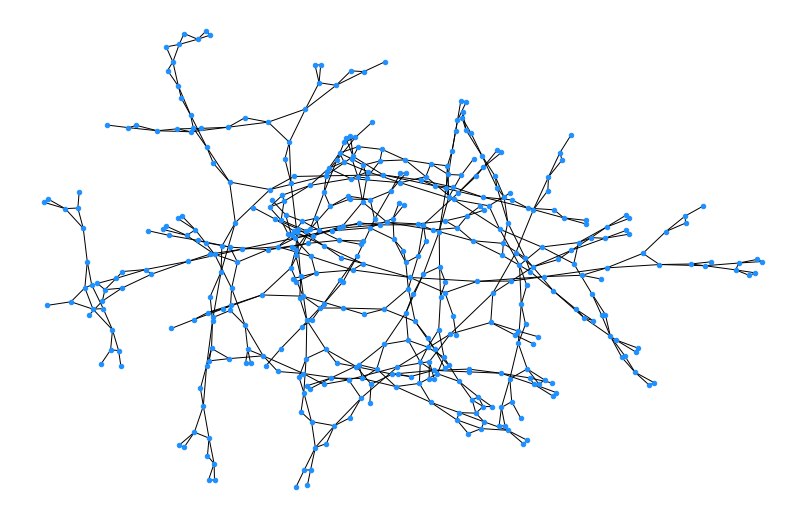

In [81]:
nx.draw(G,pos=nx.spring_layout(G), with_labels=False, node_color='#1E90FF', node_size=20) 

### Функция distance_attr
Задача: Присваивание весов ребрам графа

Input:
* G --- исходный граф
* start --- вершина, из которой требуется начинать обход
* dataframe --- pandas датафрейм, в котором присутствую 2 столбца: 'id' (идентификатор сегмента/вершины) и 'length' (длина данного сегмента)

Output:
* На исходном графе ребрам присваиваются веса на ребра таким образом, что если начальная вершина 1, соседние с ней узлы графа: 2 и 3, где значение атрибута 'length' для сегментов 1 - 10, 2 - 15, 3 - 20. В результате ребрам будет присвоены значения следующим образом: (1, 2) и (2, 1) - 15; (1, 3) и (3, 1) - 20 и т.д.
* last_vertex --- одна из самых удаленных вершин от начальной в графе (даная вершина необхоима для нахождения кратчайшег пути между двумя самыми удаленными сегментами в речной сети)

> В рамках данной функции осуществляется также выделение одной компоненты связности в графе. Все вершины, которые не входят в данный подграф, удаляются

In [72]:
# Функция присваивания весов ребрам графа
def distance_attr(G, start, dataframe):
      
    # Список со всеми вершинами, до которых можно добраться из точки start
    # при помощи поиска в ширину
    vert_list = list(nx.bfs_successors(G, source=start))
    # Одна из самых удаленных вершин в графе (это необходимо будет для A*)
    last_vertex = vert_list[-1][-1][0]
    
    for component in vert_list:
        vertex = component[0]  # Вершина в которой находимся на данной итерации
        neighbors = component[1]  # Вершины, которые являются соседними (которые мы еще не посещали)
        
        attrs = {vertex: {'component' : 1}}
        nx.set_node_attributes(G, attrs)
        
        for n in neighbors:
            attrs = {n: {'component' : 1}}
            nx.set_node_attributes(G, attrs)
            
            # Присваиваем веса на ребра графа
            # Значение протяженности участка в метрах (int)
            dist_n = int(dataframe['length'][dataframe['id'] == n])
            attrs = {(vertex, n): {'weight': dist_n},
                     (n, vertex): {'weight': dist_n}}
            nx.set_edge_attributes(G, attrs)
            
        # Осматриваем окрестности вершины в которой находимся
        offspring = list(nx.bfs_successors(G, source = vertex, depth_limit = 1)) 
        offspring = offspring[0][1]
        # Если значение веса не было присвоено - присваиваем его
        for n in offspring:
            
            if len(G.get_edge_data(vertex, n)) == 0:
                dist_n = int(dataframe['length'][dataframe['id'] == n])
                attrs = {(vertex, n): {'weight': dist_n},
                         (n, vertex): {'weight': dist_n}}
                nx.set_edge_attributes(G, attrs)
            elif len(G.get_edge_data(n, vertex)) == 0:
                dist_n = int(dataframe['length'][dataframe['id'] == n])
                attrs = {(vertex, n): {'weight': dist_n},
                         (n, vertex): {'weight': dist_n}}
                nx.set_edge_attributes(G, attrs)     
        
    for vertex in list(G.nodes()):
        # Если граф неполносвязный, то удаляем те элементы, до которых мы не можем добраться
        if G.nodes[vertex].get('component') == None:
            G.remove_node(vertex)
        else:
            pass    
    return(last_vertex)    

# Применение алгоритма
last_vertex = distance_attr(G, '293', dataframe)

### Функция attr_set
Задача: Присваивание атрибутов 'rank' и 'offspring' вершинам графа

Input:
* G --- граф с присвоенными весами на ребрах
* start --- вершина, из которой требуется начинать обход
* last_vertex --- одна из самых удаленных вершин от начальной в графе

Output:
* Каждой вершине графа присваивается значение его ранга в речной сети. Ранг 1 имеет сегмент реки, который является замыкающим в речной сети. Ранг 2 имеют притоки, которые впадают в сегмент ранга 1. Ранг 3 имеют притоки, которые впадают в сегмент ранга 2 и т.д. После того, как все вершины графа имеют значение атрибута 'rank', производится подсчет потомков для каждой вершины 'offspring'. Значение атрибута 'offspring' можно интерпретировать как 'количество сегментов, которое впадает в данный сегмент речной сети'. 

Подробное описание:
Между двумя вершинами (start и last_vertex) на взвешенном графе G с помощью алгоритма A* ищется маршрут с наименьшей длиной. После, проверяется корректность построенного маршрута и осушествляется его модификация, если выясняется, что построенный маршрут не оптимален (из-за неточностей в исходном векторном слое).  

Полученный маршрут будет являться опорным, играть роль совеобразного "якоря", который будет удерживать алгоритм от включения возмущений в конечный результат. Всем вершинам опорного маршрута присваивается значение атрибута rank от 1 до максимально возможного значения в данной речной сети.

Затем, каждая опорная вершина изолируется от других опорных. После чего запускается поиск в ширину по полученному подграфу с присваиванием атрибута 'rank' вершинам. Важно: подграф также изолируется от других опорных вершин.

Упрощенная схема обхода графа описанным образом представлена ниже:

![animation_graph_2.gif](https://raw.githubusercontent.com/Dreamlone/State_Hydrological_Institute/master/images/animation_graph_2.gif)

In [73]:
# Функция для присваивания атрибутов вершинам графа
def attr_set(G, start, last_vertex):
    
    # Обход графа с присваиванием атрибутов
    # G           --- граф как объект networkx
    # vertex      --- вершина, из которой начинается обход графа
    # kernel_path --- список вершин, входящих в главный путь, от которого строится обход
    def bfs_attributes(G, vertex, kernel_path):
        
        # Создаем копию графа
        G_copy = G.copy()
        
        # Удаляем все ребра, которые связаны с опорными вершинами
        for kernel_vertex in kernel_path:
            # Оставляем опорную вершину, из которой начинаем обход
            if kernel_vertex == vertex:
                pass
            else:
                # Для всех остальных вершин - производим удаление рёбер
                kernel_n = list(nx.bfs_successors(G_copy, source = kernel_vertex, depth_limit = 1))   
                kernel_n = kernel_n[0][1]
                for i in kernel_n:
                    try:
                        G_copy.remove_edge(i, kernel_vertex)
                    except Exception:
                        pass
                    
        # Полученный подграф изолирован от всех опорных вершин, кроме той, из которой 
        # начинается обход на данной итерации               
                        
        # Обходим граф в ширину
        all_neighbors = list(nx.bfs_successors(G_copy, source = vertex))    
        
        #########################################################################
        #                              Внимание!                                #
        # Метки присваиваются не на изолированном подграфе, а на исходном графе #
        #########################################################################
        for component in all_neighbors:
            v = component[0] # Вершина в которой находимся на данной итерации
            neighbors = component[1] # Вершины, которые являются соседними (которые мы еще не посещали)
            
            # Значение атрибута в рассматриваемой вершине
            att = G.nodes[v].get('rank')
            if att != None:
                # Значение атрибута, которое будет присвоено соседним вершинам
                att_number = att + 1

            # Смотрим на всех ближайших прямых потомков
            first_n = list(nx.bfs_successors(G, source = v, depth_limit = 1))   
            first_n = first_n[0][1]

            # Присваиваем ранги вершинам
            for i in first_n: 
                # Если соседняя вершина - главный узел на данной итерации, то пропускаем его
                # vertex - опорная точка, из которой мы начинали обход
                if i == vertex:
                    pass 
                else:
                    current_i_rank = G.nodes[i].get('rank')
                    # Если значение ранга еще не присвоено, то присваиваем его
                    if current_i_rank == None:
                        attrs = {i: {'rank': att_number}}
                        nx.set_node_attributes(G, attrs)
                    # Если ранг в данном узле уже присвоен
                    else:
                        # Алгоритм либо "смотрит назад" на вершины, которые уже посетил
                        # В таком случае мы ничего не делаем
                        # Либо алгоритм "подошел" к главному пути в графе
                        if any(i == bearing_v for bearing_v in kernel_path):
                            G.remove_edge(v, i)
                        else:
                            pass
            
            # Дополнительный "дообход"
            for v in neighbors:
                # Смотрим на всех ближайших прямых потомков
                first_n = list(nx.bfs_successors(G, source = v, depth_limit = 1))   
                first_n = first_n[0][1]

                for i in first_n: 
                    # Если соседняя вершина - главный узел на данной итерации, то пропускаем его
                    # vertex - опорная точка, из которой мы начинали обход
                    if i == vertex:
                        pass 
                    else:
                        # Алгоритм либо "смотрит назад" на вершины, которые уже посетил
                        # В таком случае мы ничего не делаем
                        # Либо алгоритм "подошел" к главному пути в графе
                        if any(i == bearing_v for bearing_v in kernel_path):
                            G.remove_edge(v, i)
                        else:
                            pass               
    
    # Поиск кратчайшего пути A* - строим маршрут, вокруг которого будем строить последующий обход
    a_path = list(nx.astar_path(G, source = start, target = last_vertex, weight = 'weight'))
    
    #######################################
    # Блок проверки корректности маршрута #
    #######################################
    true_a_path = []
    for index, V in enumerate(a_path):
        
        if index == 0:
            true_a_path.append(V)
        elif index == (len(a_path) - 1):
            true_a_path.append(V)
        else:
            # Предыдущая и последующая вершины для опорного маршрута
            V_prev = a_path[index - 1]
            V_next = a_path[index + 1]
            
            # Какие вершины соседствуют с данной
            V_prev_neighborhood = list(nx.bfs_successors(G, source = V_prev, depth_limit = 1)) 
            V_prev_neighborhood = V_prev_neighborhood[0][1]
            V_next_neighborhood = list(nx.bfs_successors(G, source = V_next, depth_limit = 1))
            V_next_neighborhood = V_next_neighborhood[0][1]
            
            # Если последующая и предыдущая вершины имеют связь друг с другом без посредника
            # в виде вершины V, то вершина V исключается из опорного маршрута
            if any(V_next == VPREV for VPREV in V_prev_neighborhood):
                if any(V_prev == VNEXT for VNEXT in V_next_neighborhood):
                    pass
                else:
                    true_a_path.append(V)
            else:
                true_a_path.append(V)
    #######################################
    # Блок проверки корректности маршрута #
    #######################################
    
    # Проверка закончена
    a_path = true_a_path     
    RANK = 1
    for v in a_path:
        # Начальной вершине присвоим значением атрибута - 1, чем дальше, тем больше значение
        attrs = {v: {'rank' : RANK}}
        nx.set_node_attributes(G, attrs) 
        RANK += 1

    # Основной маршрут готов, затем мы итеративно будем продвигаться от каждого узла
    for index, vertex in enumerate(a_path):
        # Начальная вершина
        if index == 0:
            next_vertex = a_path[index + 1]
            
            # Размыкаем вершины 
            G.remove_edge(vertex, next_vertex)           
            
            # Блок обхода подграфа в ширину
            bfs_attributes(G, vertex = vertex, kernel_path = a_path)      
            
            # Смыкаем вершины обратно
            G.add_edge(vertex, next_vertex)
    
        # Замыкающая вершина
        elif index == (len(a_path) - 1):
            prev_vertex = a_path[index - 1]
            
            # Размыкаем вершины 
            G.remove_edge(prev_vertex, vertex)
            
            # Блок обхода подграфа в ширину
            bfs_attributes(G, vertex = vertex, kernel_path = a_path)
            
            # Смыкаем вершины обратно
            G.add_edge(prev_vertex, vertex)
            
        # Вершины, которые являются не первыми и не последними в опорном маршруте
        else:
            prev_vertex = a_path[index - 1]
            next_vertex = a_path[index + 1]
            
            # Размыкаем вершины 
            G.remove_edge(prev_vertex, vertex)
            G.remove_edge(vertex, next_vertex)
            
            # Блок обхода подграфа в ширину
            bfs_attributes(G, vertex = vertex, kernel_path = a_path)
            
            # Замыкаем вершины 
            G.add_edge(prev_vertex, vertex)
            G.add_edge(vertex, next_vertex)
    
    # Блок присваивания атрибута - количество потомков 
    vert_list = list(nx.bfs_successors(G, source = start)) 
    for component in vert_list:
        vertex = component[0] # Вершина в которой находимся на данной итерации
        neighbors = component[1] # Вершины, которые являются соседними (которые мы еще не посещали)
        
        # Добавление атрибута - количество потомков у данной вершины
        n_offspring = len(neighbors)
        attrs = {vertex: {'offspring' : n_offspring}}
        nx.set_node_attributes(G, attrs)


start = timeit.default_timer()  # Засекаем время
attr_set(G, '293', last_vertex)
print('Runtime -', timeit.default_timer() - start, '\n') 

Runtime - 0.17874819299322553 



### Функция iter_sets
Задача: Присваивание вршинам графа атрибута 'value'.

Input:
* G --- граф с присвоенными значениями атрибутов 'rank' и 'offspring'
* start --- вершина, из которой требуется начинать обход

Output:
* Каждой вершине графа G присваивается значение атрибута 'value'. Значение данного атрибута можно интерпретировать как 'количество совокупно впадающих притоков в данную часть речной сети'.

Подробное описание: Алгоритм вызывает функцию set_values ровно столько раз, сколько рангов было обнаружено в рассматриваемой речной сети. Алгоритм сначала присваивает значение 'value' = 1 тем вершинам, у которых нет впадающих в них сегментов (значение атрибута 'offspring' равно None), а затем последовательно приближается к начальной вершине.

In [74]:
# Функция для определения порядка сегментов реки по аналогии с методом Шреве
def set_values(G, start):    
    # Список со всеми вершинами, до которых можно добраться из точки start
    # при помощи поиска в ширину
    vert_list = list(nx.bfs_successors(G, source = start)) 

    # Цикл обхода графа с присваиванием меток вершинам
    # Каждая компонента - это небольшой подграф
    for component in vert_list:
        vertex = component[0] # Вершина в которой находимся на данной итерации
        neighbors = component[1] # Вершины, которые являются соседними (которые мы еще не посещали)
        
        att_rank = G.nodes[vertex].get('rank')
        att_offspring = G.nodes[vertex].get('offspring')
        
        # Для замыкающего сегмента производим следующую процедуру:
        if att_rank == 1:
            # Определяем потомков
            offspring = list(nx.bfs_successors(G, source = vertex, depth_limit = 1)) 
            # Используем только ближайших к данной вершине соседей (прямых потомков)
            offspring = offspring[0][1]
            
            # Записываем в список значения атрибутов value у всех потомков
            last_values = []
            for child in offspring:
                if G.nodes[child].get('value') != None:
                    last_values.append(G.nodes[child].get('value'))
                else:
                    last_values.append(0)
                    
            last_values = np.array(last_values)
            sum_values = np.sum(last_values)
            
            # Если сумма не равна 0, то атрибут присваивается
            if sum_values != 0:
                attrs = {vertex: {'value' : sum_values}}
                nx.set_node_attributes(G, attrs)
            # Иначе алгоритм просто еще не дошел, пропускаем этот пункт
            else:
                pass
            
        # Для каждого соседа производим присваивание атрибута
        for i in neighbors:
            # Значение атрибутов в рассматриваемой вершине
            att_rank = G.nodes[i].get('rank')
            att_offspring = G.nodes[i].get('offspring')
            
            # Если у вершины на предыдущем этапе не было найдено потомков, то ей присваивается значение 1
            if att_offspring == None:
                attrs = {i: {'value' : 1}}
                nx.set_node_attributes(G, attrs)            
            # Если вершина имеет потомков, то необходимо определить значения атрибута "value" в них
            else:
                # Производим поиск всех потомков
                offspring = list(nx.bfs_successors(G, source = i, depth_limit = 1)) 
                # Используем только ближайших к данной вершине соседей (прямых потомков)
                offspring = offspring[0][1]

                # Цикл определения значений в вершинах - потомках
                last_values = []
                for child in offspring:
                    # Нужны только те потомки, значение ранга которых строго больше, чем у рассматриваемой вершины
                    if G.nodes[child].get('rank') > att_rank:
                        if G.nodes[child].get('value') != None:
                            last_values.append(G.nodes[child].get('value'))
                        else:
                            pass
                    else:
                        pass
                    
                last_values = np.array(last_values)
                sum_values = np.sum(last_values)
                
                # Если сумма не равна 0, то атрибут присваивается
                if sum_values != 0:
                    attrs = {i: {'value' : sum_values}}
                    nx.set_node_attributes(G, attrs)
                # Иначе алгоритм просто еще не дошел, пропускаем этот пункт
                else:
                    pass

# Поскольку мы начинаем обход графа из стартовой точки, то нам необходимо производить несколько итераций последовательно
# Функция для итеративного обхода
def iter_sets(G, start):
    # Определяем максимальное значение ранга в данном графе
    ranks = []
    for vertex in list(G.nodes()):
        ranks.append(G.nodes[vertex].get('rank'))
    max_rank = max(ranks) 
    
    # Мы должны проитерировать ровно столько раз, сколько рангов есть в графе
    for iteration in range(0, max_rank):
        set_values(G, start)
        
        
# Применение алгоритма
start = timeit.default_timer()  # Засекаем время

# Применение алгоритма: запускаем функцию iter_sets
iter_sets(G, '293')

print('Runtime -', timeit.default_timer() - start, '\n') 

Runtime - 0.4401511960022617 



Сохранение результата в shp файл

In [78]:
# Составляем датасет, где каждая вершина - строка
def make_dataframe(G):    
    dataframe = []
    for vertex in list(G.nodes()):
        rank = G.nodes[vertex].get('rank')
        value = G.nodes[vertex].get('value')
        dataframe.append([vertex, rank, value])

    dataframe = pd.DataFrame(dataframe, columns = ['id', 'Rank', 'Value'])
    return(dataframe)
    
dataframe = make_dataframe(G)

# Загружаем исходный слой с реками
rivers = geopandas.read_file('/media/mikhail/Data1/Ob/URAL_test/split_with_length.shp')
rivers = rivers.astype({'id': 'str'})

# Объединяем датасеты
data_merged = pd.merge(rivers, dataframe, on = 'id')
# Сохраняем в файл
data_merged.to_file("/media/mikhail/Data1/Ob/URAL_test/Result.shp")